# Bayesian A/B Testing with Gamma distributed sales
Credit to author Cuong Duong from who I adapted their work.
https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_ab_testing_introduction.html

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import bernoulli, expon

In [ ]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

plotting_defaults = dict(
    bins=500,
    kind="hist",
    textsize=10,
    hdi_prob=0.95,
    round_to=2,
)

In [ ]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

@dataclass
class BinomialData:
    trials: int
    successes: int

@dataclass
class GammaPrior:
    alpha: float
    beta: float

@dataclass
class RevenueData:
    visitors: int
    purchased: int
    total_revenue: float

## An example Gamma distribution of sales

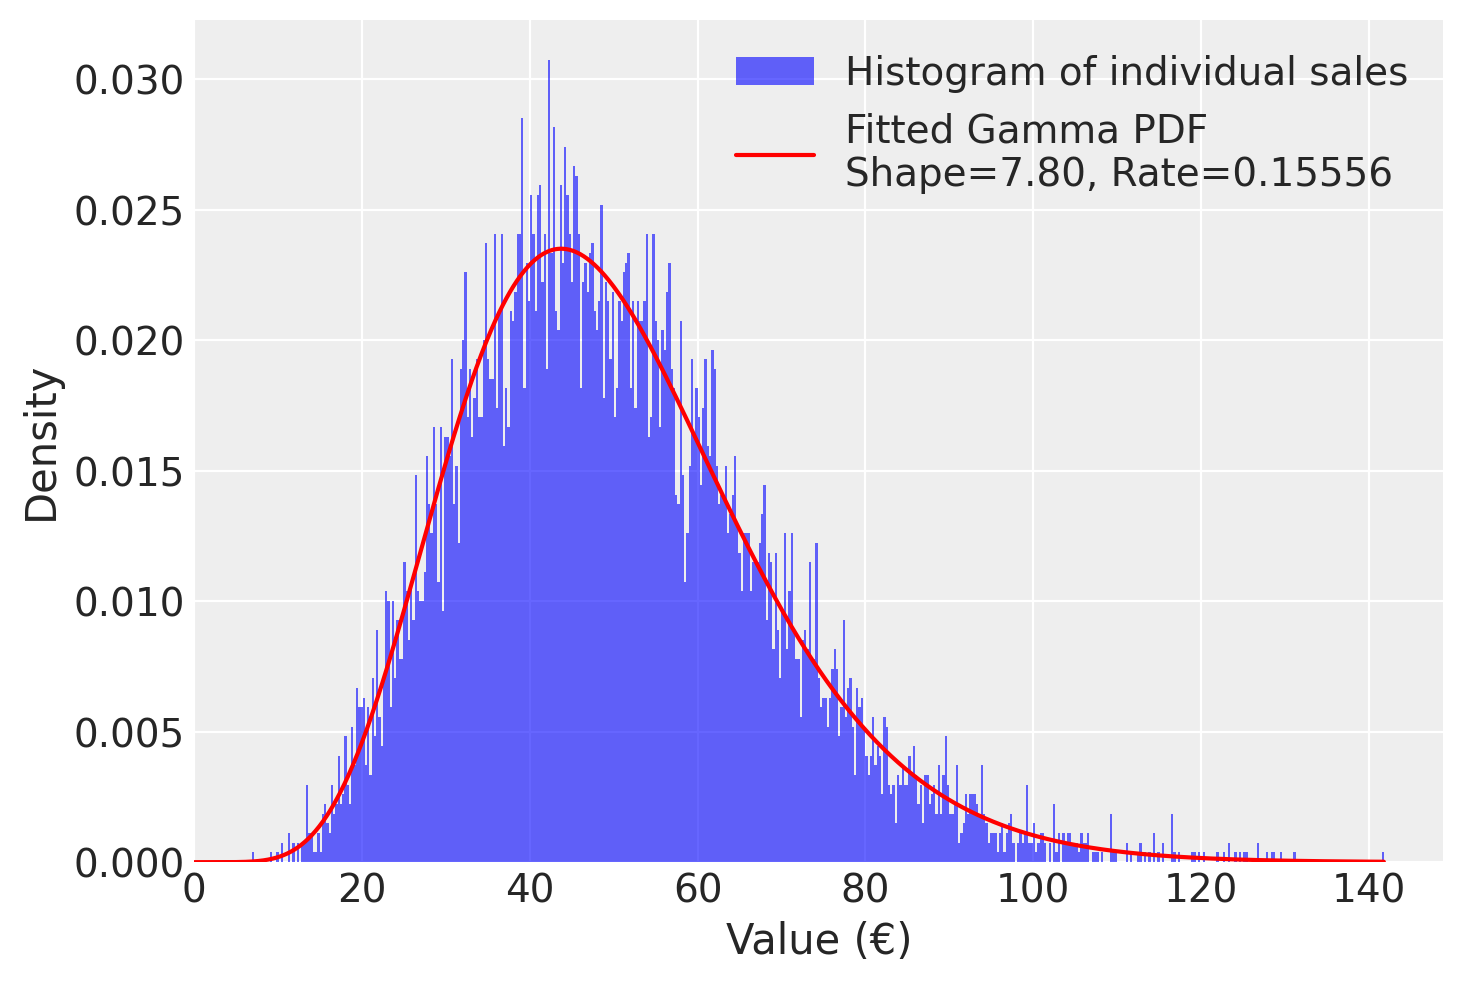

Fitted shape: 7.802571409577548
Fitted rate: 0.15556115977960605
Fitted mean: 50.15758059808744
Fitted variance: 322.4299733246336
Fitted standard deviation: 17.956335186352298


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Step 1: Generate synthetic data
shape = 8  # Shape parameter (k)
scale = 50/8  # Scale parameter (θ), so that mean = shape * scale = 10
synthetic_sale_data = np.random.gamma(shape, scale, 10000)

# Step 2: Fit a gamma distribution to the synthetic data
fitted_shape, loc, fitted_scale = gamma.fit(synthetic_sale_data, floc=0)

# Step 3: Calculate the mean, variance, and standard deviation of the fitted gamma distribution
fitted_mean = fitted_shape * fitted_scale  # Mean of the gamma distribution
fitted_variance = fitted_shape * (fitted_scale ** 2)  # Variance of the gamma distribution
fitted_std_dev = np.sqrt(fitted_variance)  # Standard deviation (square root of variance)

# Step 4: Plot the histogram of the data
plt.hist(synthetic_sale_data, bins=500, density=True, alpha=0.6, color='blue', label="Histogram of individual sales")

# Generate values for the PDF plot based on the fitted gamma distribution
x = np.linspace(0, np.max(synthetic_sale_data), 1000)
fitted_pdf = gamma.pdf(x, fitted_shape, loc, fitted_scale)

# Step 5: Plot the fitted gamma distribution PDF
plt.plot(x, fitted_pdf, 'r-', label=f'Fitted Gamma PDF\nShape={fitted_shape:.2f}, Rate={1/fitted_scale:.5f}')
plt.xlabel('Value (€)')
plt.ylabel('Density')
plt.xlim(0)
plt.ylim(0)
plt.legend()
plt.show()

print(f"Fitted shape: {fitted_shape}")
print(f"Fitted rate: {1/fitted_scale}")
print(f"Fitted mean: {fitted_mean}")
print(f"Fitted variance: {fitted_variance}")
print(f"Fitted standard deviation: {fitted_std_dev}")


## Define priors
Create priors using domain knowledge

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, beta

# Define Prior for the conversion rate
x0 = np.linspace(0,0.04)
a0=21
b0=1000-21
pdf0 = beta.pdf(x0, a0, b0)

# Define prior parameters for shape, k
shape_k = 10
scale_k = 7.8/10

# Define prior parameters for rate, lambda
shape_l = 10
scale_l =0.15664/shape_l

x = np.linspace(0, 16, 100)
x2 = np.linspace(0, 0.3, 100)
pdf1 = gamma.pdf(x, shape_k, scale=scale_k)
pdf2 = gamma.pdf(x2, shape_l, scale=scale_l)


<ipython-input-7-4e81ac2583e5>:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


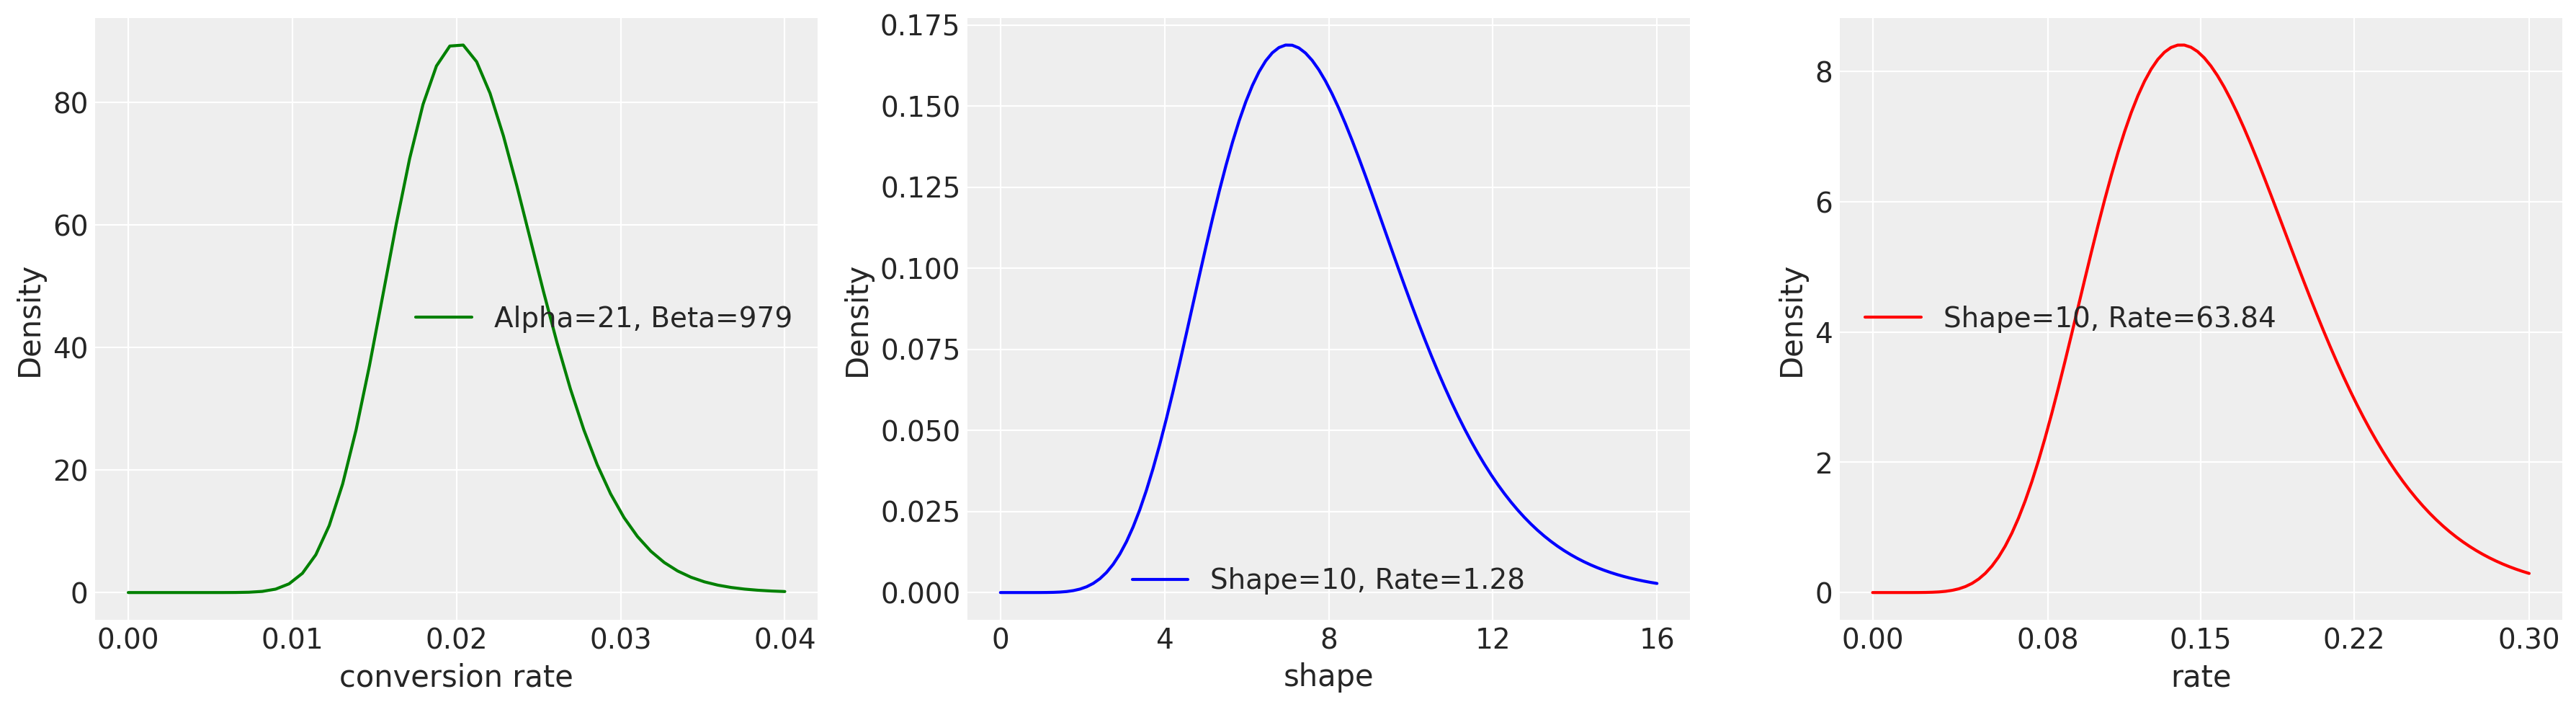

In [ ]:
# Create a subplot with 1 row and 3 columns, adjusting the order of the plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot conversion rate
axs[0].plot(x0, pdf0, label=f'Alpha={a0}, Beta={b0}', color='g')
axs[0].set_xlabel('conversion rate')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xticks(np.round(np.linspace(min(x0), max(x0), 5), 2))  # Limit xticks to 2 decimal places

# Plot shape prior
axs[1].plot(x, pdf1, label=f'Shape={shape_k}, Rate={1/scale_k:.2f}', color='blue')
axs[1].set_xlabel('shape')
axs[1].set_ylabel('Density')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xticks(np.round(np.linspace(min(x), max(x), 5), 2))  # Limit xticks to 2 decimal places

# Plot rate prior
axs[2].plot(x2, pdf2, label=f'Shape={shape_l}, Rate={1/scale_l:.2f}', color='red')
axs[2].set_xlabel('rate')
axs[2].set_ylabel('Density')
axs[2].legend()
axs[2].grid(True)
axs[2].set_xticks(np.round(np.linspace(min(x2), max(x2), 5), 2))  # Limit xticks to 2 decimal places

# Show the plot
plt.tight_layout()
plt.show()


## Revenue model
Adap the revenue model originally provided to model Gamma distributed sales

In [ ]:
class RevenueModel:
    def __init__(self, conversion_rate_prior: BetaPrior, shape_prior: GammaPrior, rate_prior: GammaPrior):
        self.conversion_rate_prior = conversion_rate_prior
        self.rate_prior = rate_prior
        self.shape_prior = shape_prior

    def create_model(self, data: List[RevenueData], comparison_method: str) -> pm.Model:
        num_variants = len(data)
        visitors = [d.visitors for d in data]
        purchased = [d.purchased for d in data]
        total_revenue = [d.total_revenue for d in data]
        with pm.Model() as model:
            theta = pm.Beta(
                "theta",
                alpha=self.conversion_rate_prior.alpha,
                beta=self.conversion_rate_prior.beta,
                shape=num_variants,
            )
            lam = pm.Gamma(
                "lam",
                alpha=self.rate_prior.alpha,
                beta=self.rate_prior.beta,
                shape=num_variants,
            )
            k = pm.Gamma(
                "k",
                alpha=self.shape_prior.alpha,
                beta=self.shape_prior.beta,
                shape=num_variants,
            )
            converted = pm.Binomial(
                "converted", n=visitors, p=theta, observed=purchased, shape=num_variants
            )

            revenue = pm.Gamma(
                "revenue", alpha=purchased * k, beta=lam, observed=total_revenue, shape=num_variants
            )

            revenue_per_sale = pm.Deterministic("revenue_per_sale", k / lam)

            revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta * (k / lam))

            theta_reluplift = []
            relative_rpv_uplift = []
            rpv_uplift = []
            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison_theta = theta[0]
                    comparison_rpv = revenue_per_visitor[0]
                elif comparison_method == "best_of_rest":
                    others_theta = [theta[j] for j in range(num_variants) if j != i]
                    others_rpv = [revenue_per_visitor[j] for j in range(num_variants) if j != i]

                    if len(others_rpv) > 1:
                        comparison_theta = pm.math.maximum(*others_theta)
                        comparison_rpv = pm.math.maximum(*others_rpv)

                    else:
                        comparison_theta = others_theta[0]
                        comparison_rpv = others_rpv[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                theta_reluplift.append(
                    pm.Deterministic(f"theta_reluplift_{i}", theta[i] / comparison_theta - 1)
                )

                relative_rpv_uplift.append(
                    pm.Deterministic(f"relative_rpv_uplift_{i}", revenue_per_visitor[i] / comparison_rpv - 1)
                )

                rpv_uplift.append(
                    pm.Deterministic(f"rpv_uplift_{i}", revenue_per_visitor[i] - comparison_rpv)
                )

        return model


In [ ]:
def run_scenario_value(
    data: List[RevenueData],
    conversion_rate_prior: BetaPrior,
    shape_prior: GammaPrior,
    rate_prior: GammaPrior,
    comparison_method: str,
) -> az.InferenceData:

    with RevenueModel(conversion_rate_prior, shape_prior, rate_prior).create_model(data, comparison_method):

      trace = pm.sample(draws=8000, cores=-1, return_inferencedata=True)


      axs = az.plot_posterior(
            trace,
            var_names=["theta", "revenue_per_visitor"],
            **plotting_defaults,
        )


    n_plots = len(data)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3 * n_plots, 7), sharex=True)
    for i, variant in enumerate(data):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f"rpv_uplift_{i}"], ax=axs[i], **plotting_defaults)

        axs[i].axvline(x=0, color="red")

    return trace

In [ ]:
### Prepare the variants

In [ ]:
data = [RevenueData(visitors=28000, purchased=604, total_revenue=1939869*50/3000),
        RevenueData(visitors=28000, purchased=634, total_revenue=2059393*50/3000),
        RevenueData(visitors=28000, purchased=603, total_revenue=1909108*50/3000),
        RevenueData(visitors=28000, purchased=637, total_revenue=2063111*50/3000),

        ]

theta_prior = BetaPrior(alpha=a0, beta=b0)
shape_prior = GammaPrior(alpha=shape_k, beta=1/scale_k)
rate_prior = GammaPrior(alpha=shape_l, beta=1/scale_l)

In [ ]:
with RevenueModel(theta_prior, shape_prior, rate_prior).create_model(data, "compare_to_control"):
    revenue_prior_predictive = pm.sample_prior_predictive(samples=4000, return_inferencedata=False)

/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:272: UserWarning: More chains (4000) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
<ipython-input-16-2bb24c10eb26>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


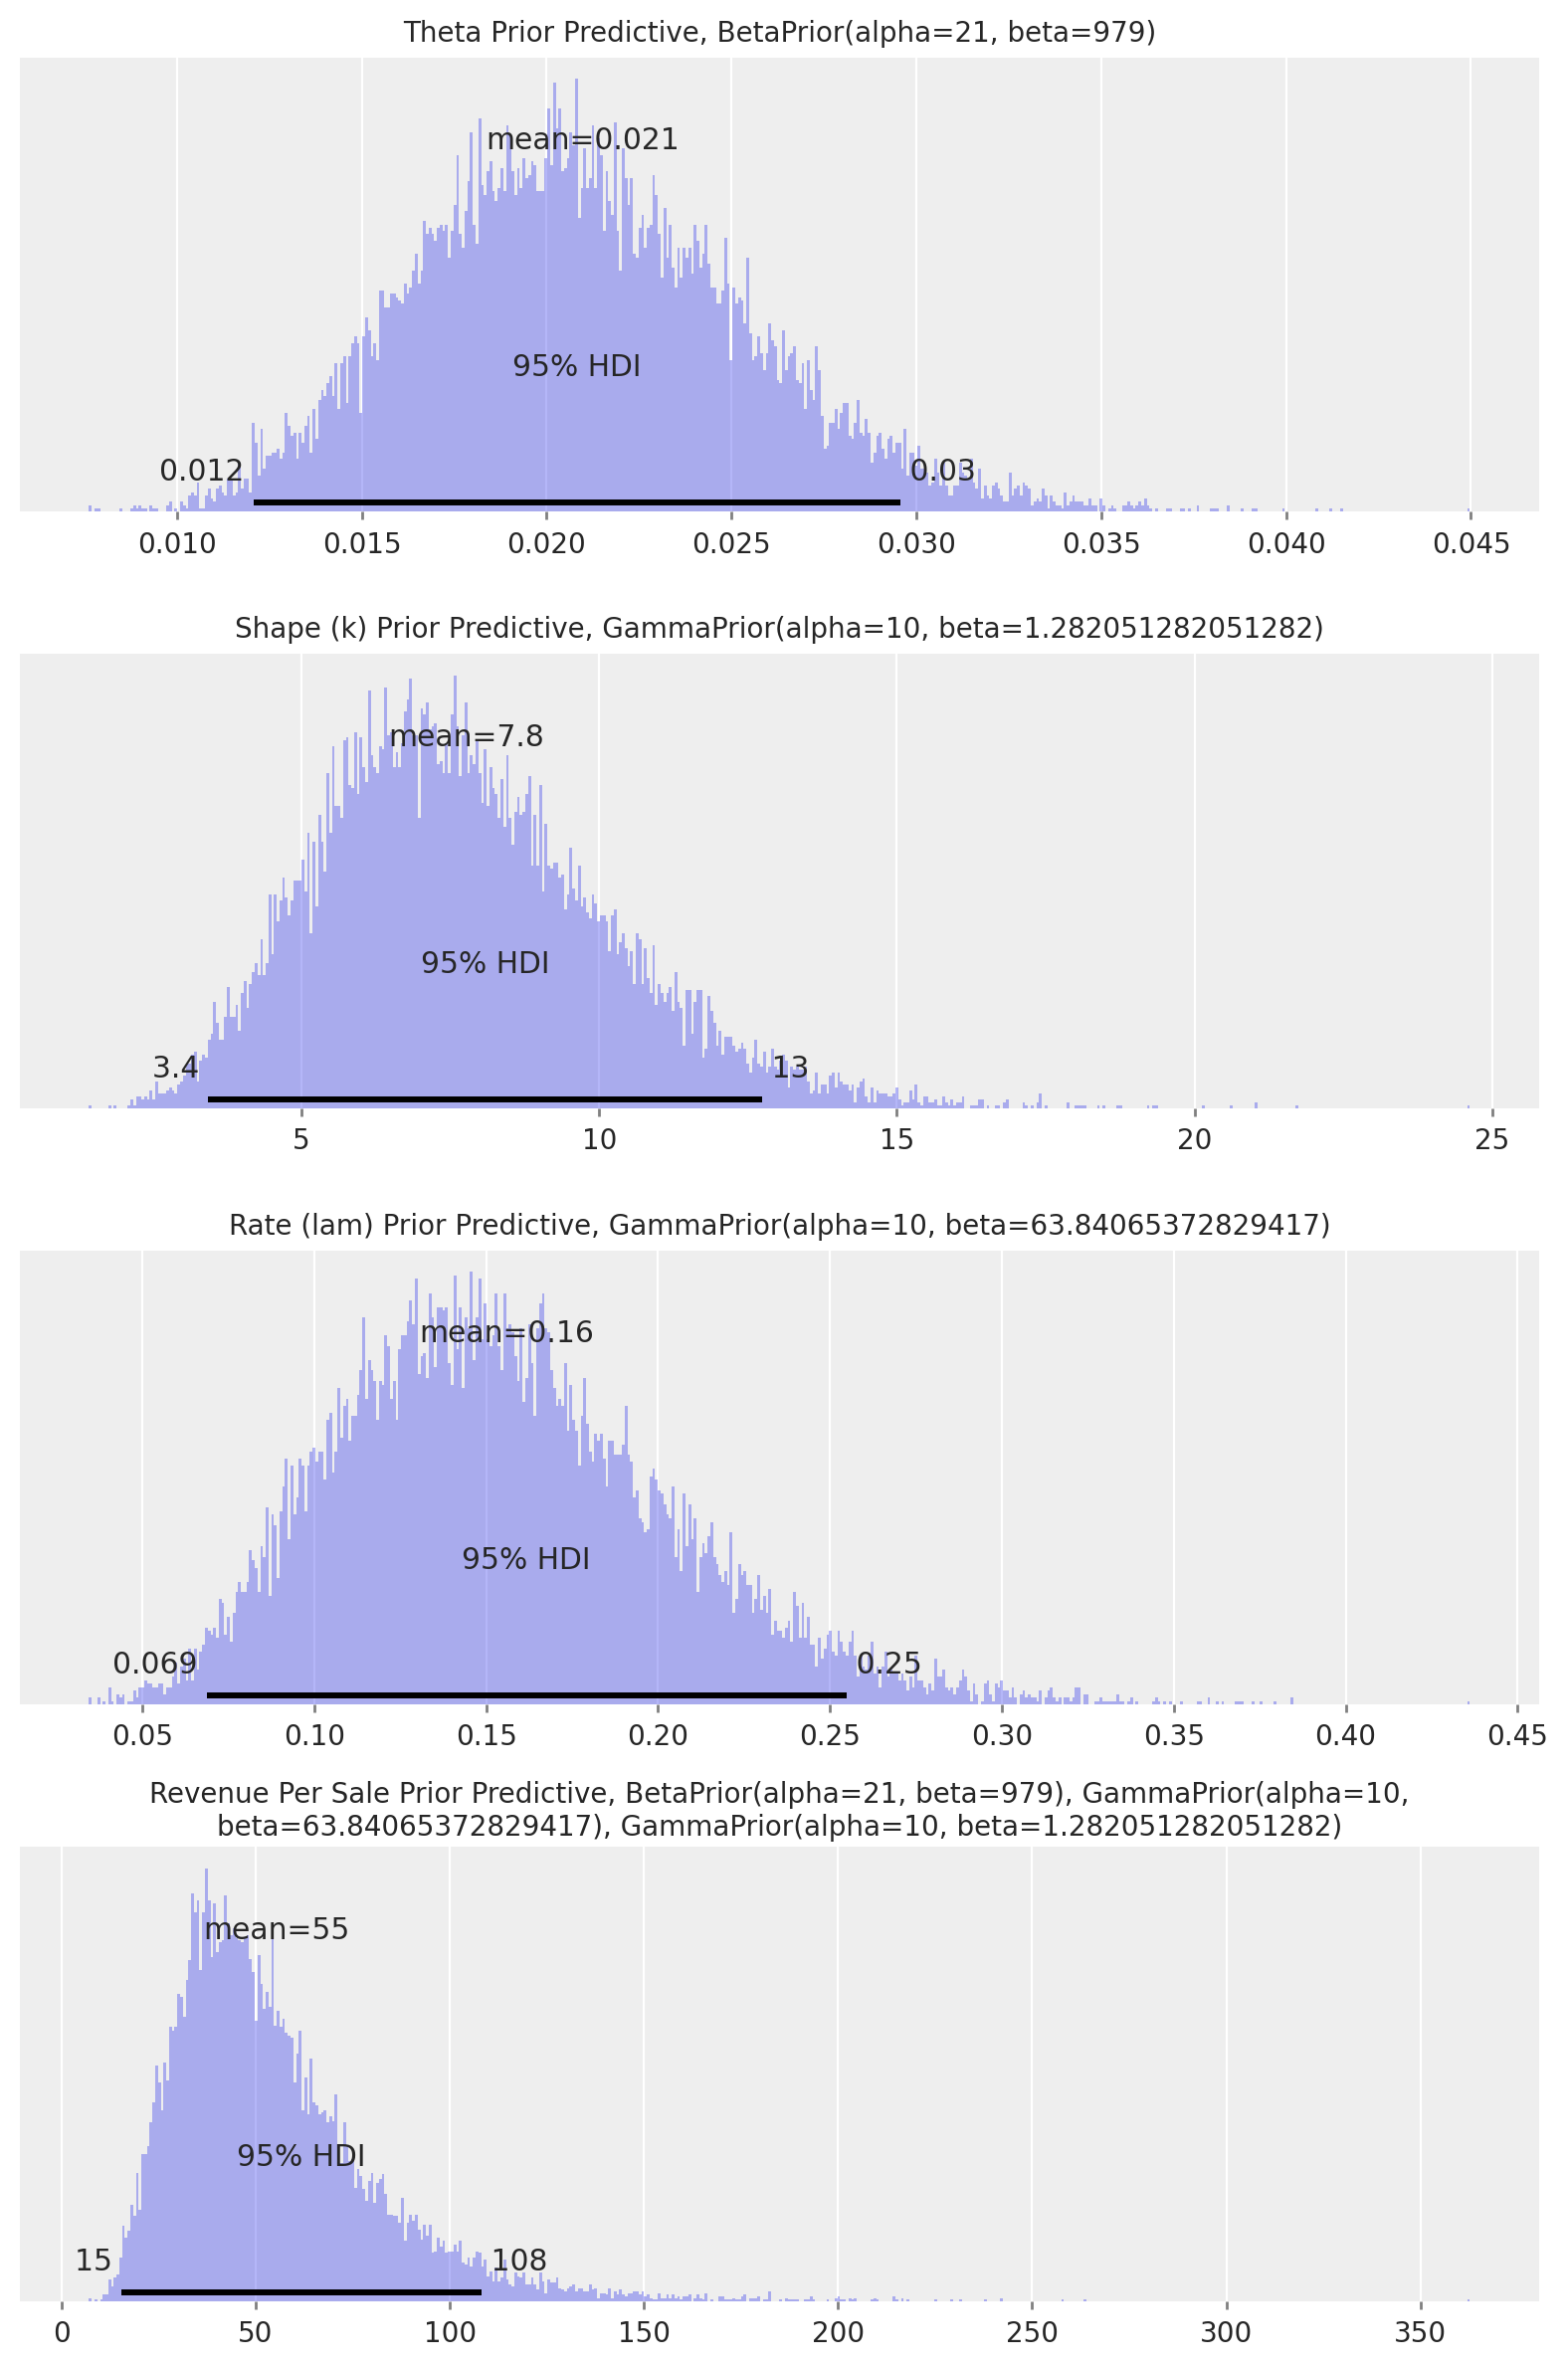

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12))  # 4 rows, 1 column

# Plot each posterior with a title
az.plot_posterior(revenue_prior_predictive["theta"], ax=axs[0], **plotting_defaults)
axs[0].set_title(f"Theta Prior Predictive, {theta_prior}", fontsize=10)

az.plot_posterior(revenue_prior_predictive["k"], ax=axs[1], **plotting_defaults)
axs[1].set_title(f"Shape (k) Prior Predictive, {shape_prior}", fontsize=10)

az.plot_posterior(revenue_prior_predictive["lam"], ax=axs[2], **plotting_defaults)
axs[2].set_title(f"Rate (lam) Prior Predictive, {rate_prior}", fontsize=10)

az.plot_posterior(revenue_prior_predictive["revenue_per_sale"], ax=axs[3], **plotting_defaults)
axs[3].set_title(f"Revenue Per Sale Prior Predictive, {theta_prior}, {rate_prior}, {shape_prior}", fontsize=10)

plt.tight_layout()
plt.show()

## Run the Analysis

Output()

Output()

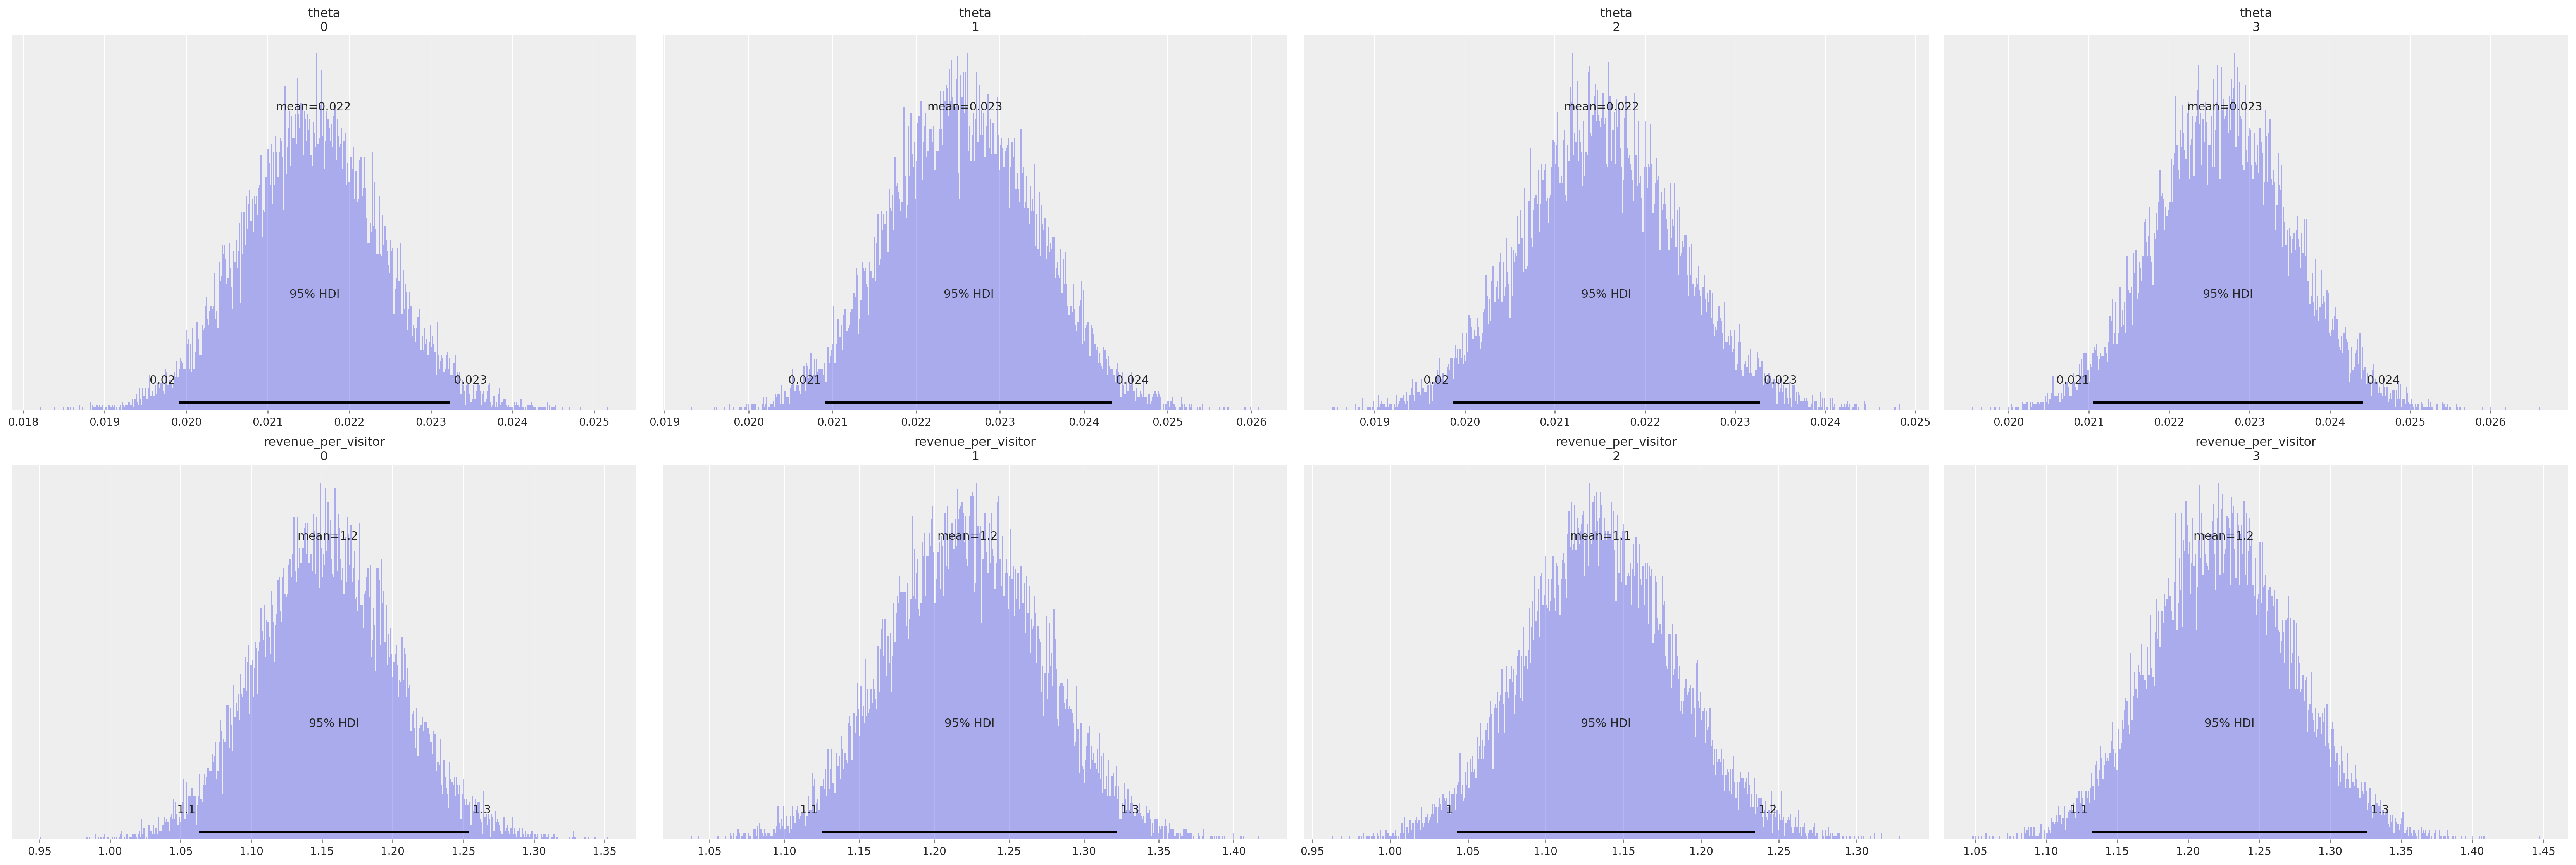

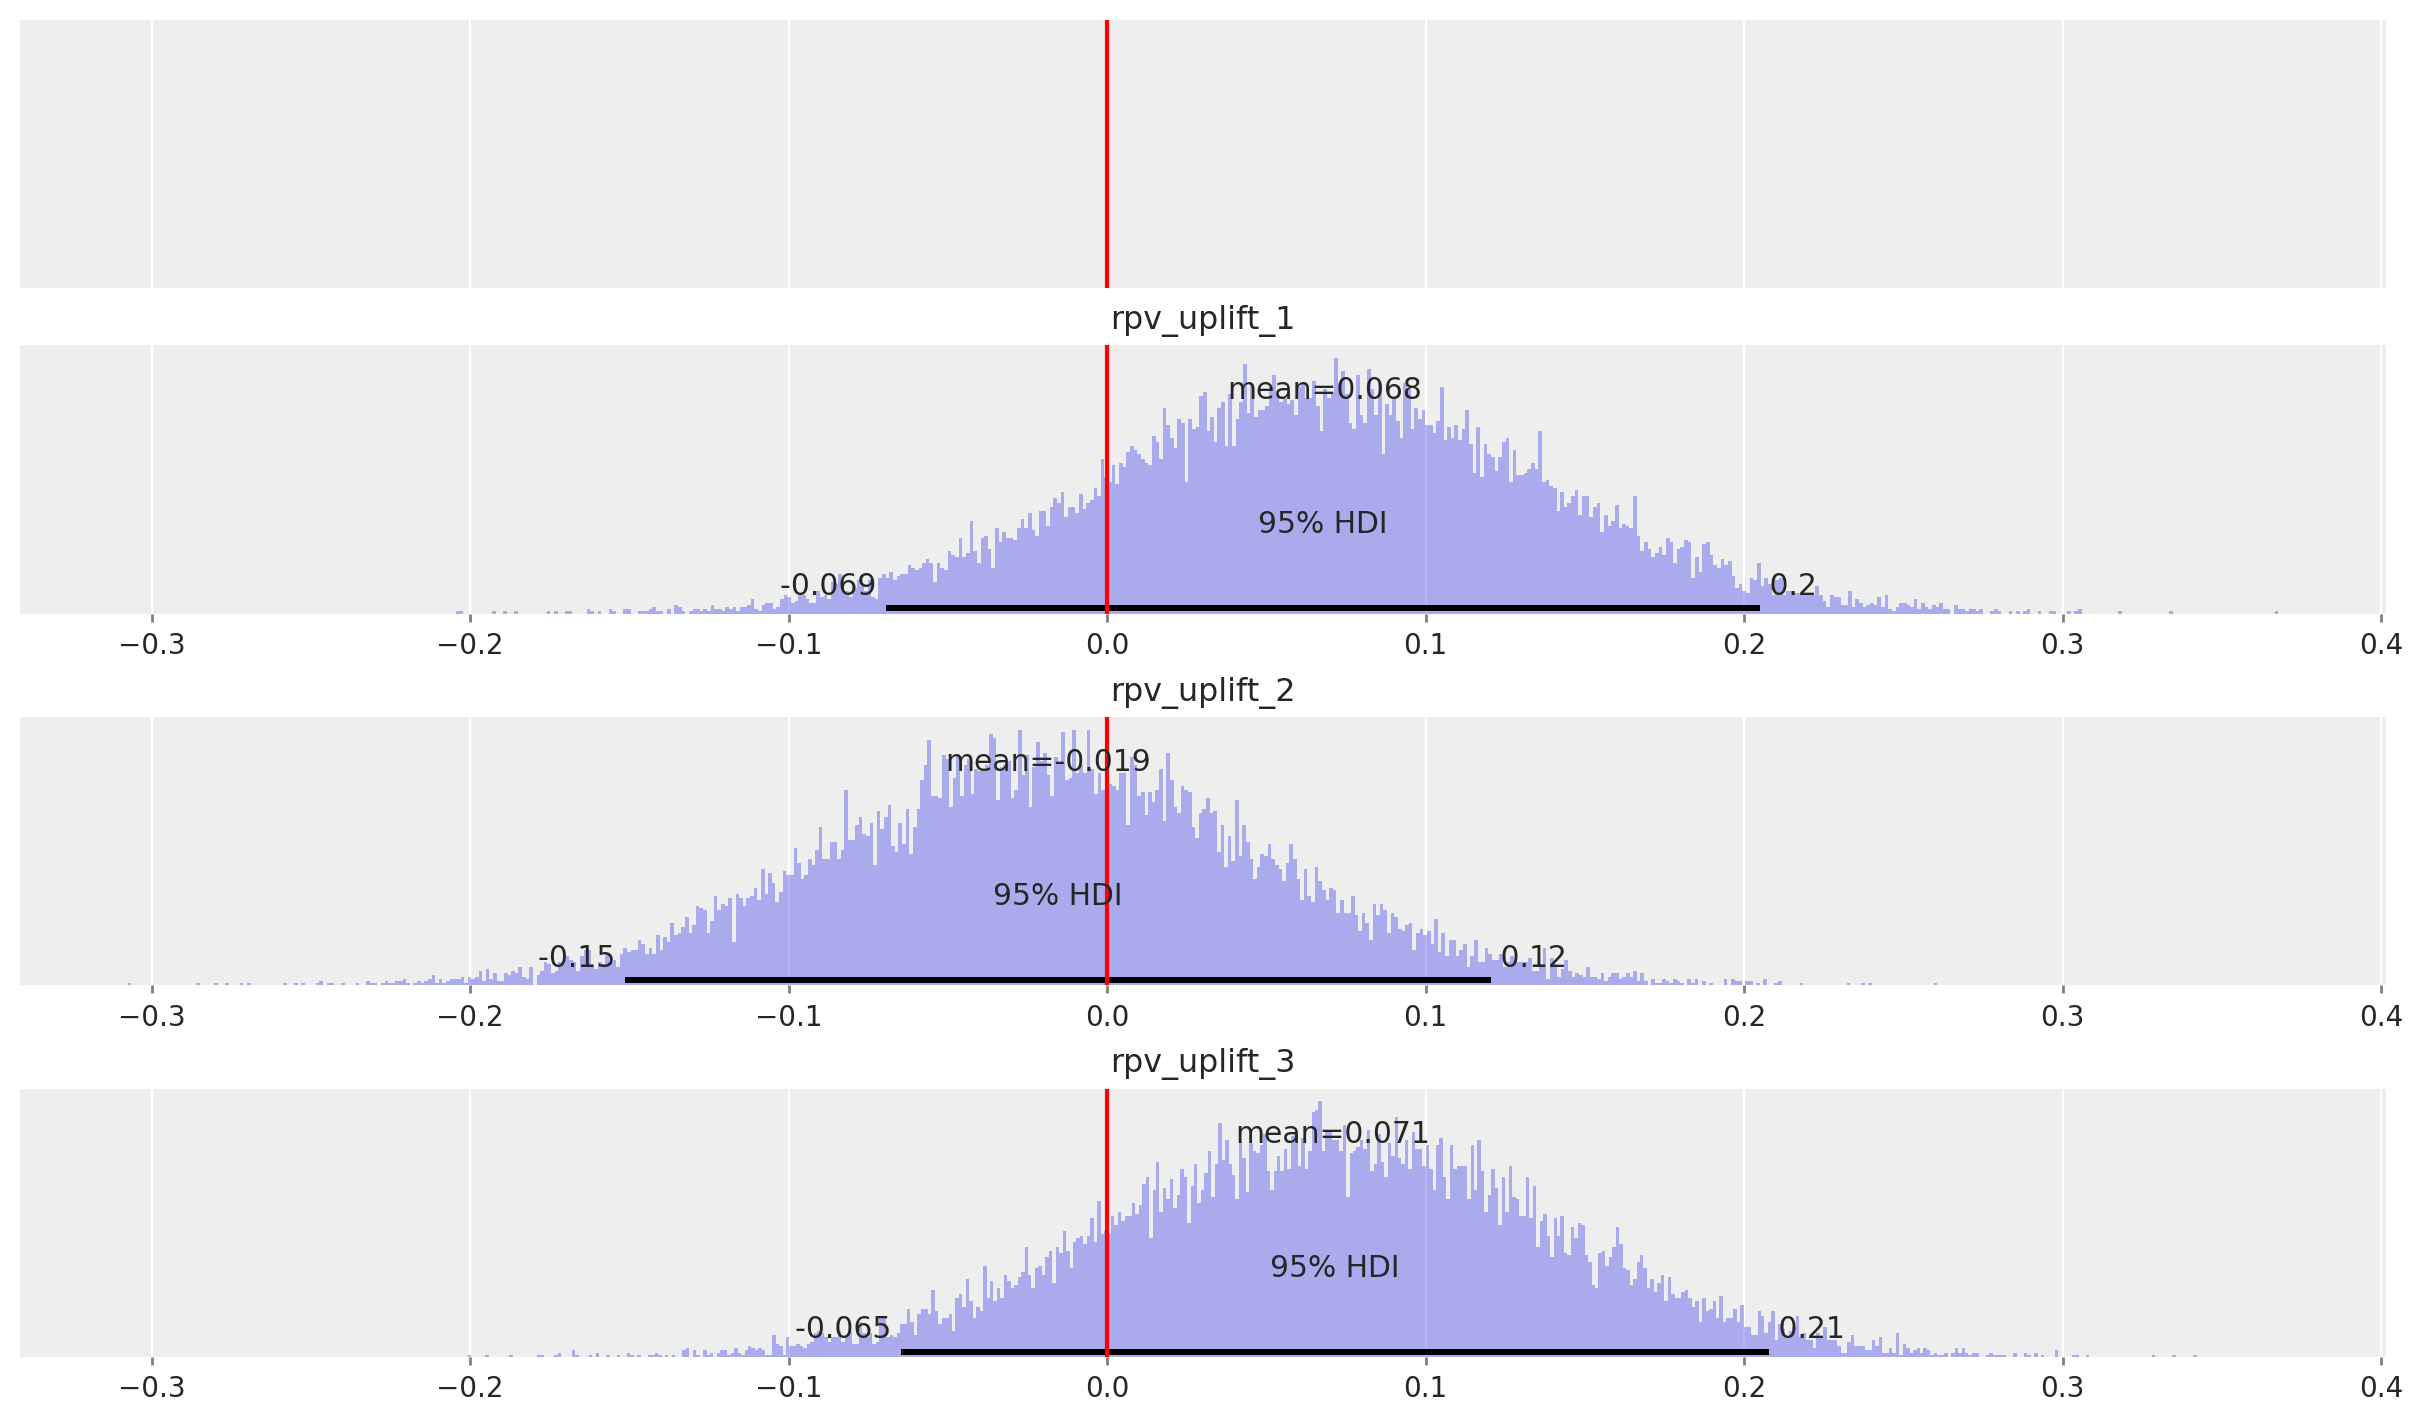

In [ ]:
scenario = run_scenario_value(data, theta_prior, shape_prior, rate_prior, "compare_to_control")

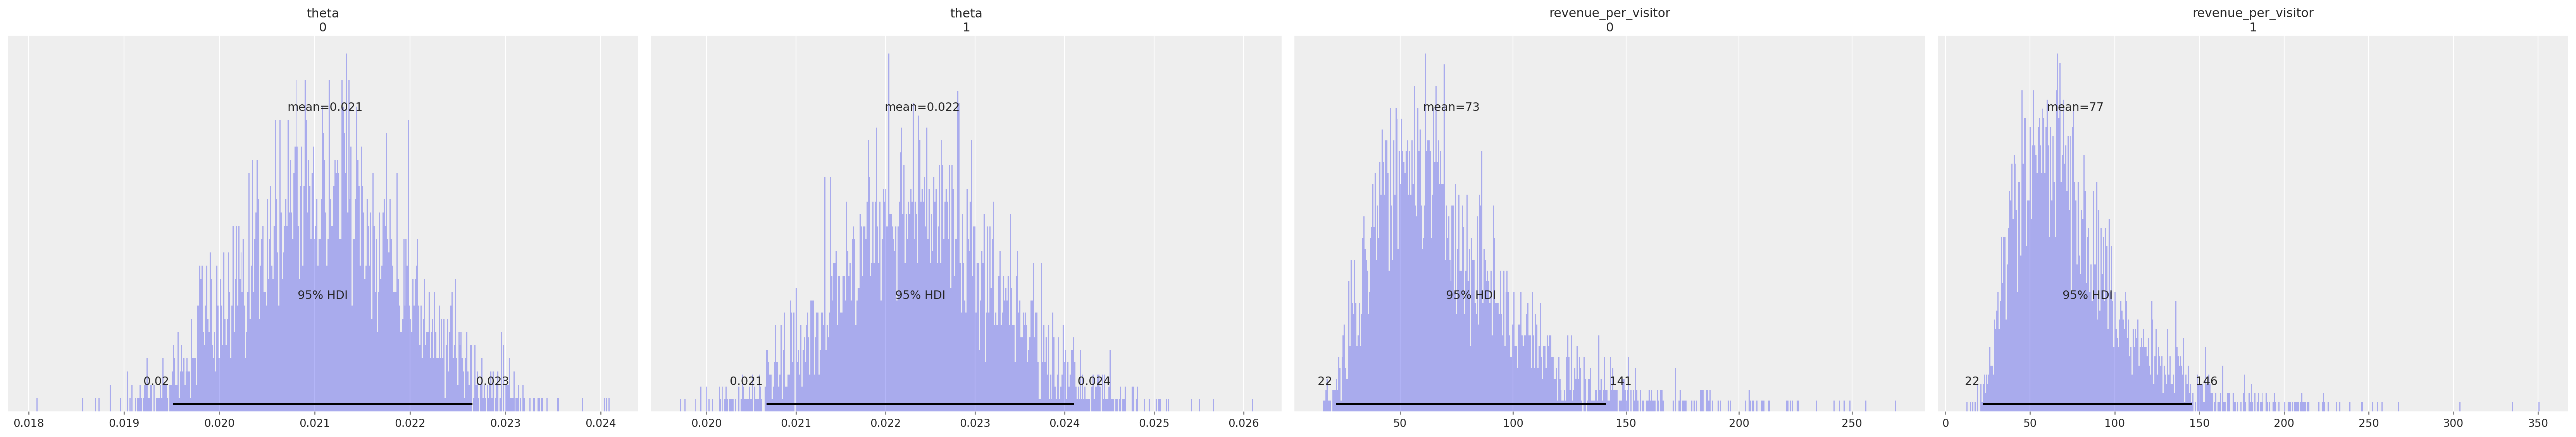

In [ ]:
axs = az.plot_posterior(
    scenario,
    var_names=["theta", "revenue_per_visitor"],
    **plotting_defaults,
)

In [ ]:
az.plot_trace(scenario)
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


## Probability to win

In [ ]:
import numpy as np
def compute_probability_and_expected_loss(
    trace,
    param_name: str,
    comparison_method: str,
    control_idx: int = 0
):
    """
    Compute the probability of winning and expected loss using the trace from PyMC sampling,
    inferring the number of variants and using variant indices.

    Parameters:
    - trace: ArviZ InferenceData object containing posterior samples.
    - param_name: Name of the parameter to analyze (e.g., 'revenue_per_visitor' or 'conversion_rate').
    - comparison_method: 'compare_to_control' or 'best_of_rest'.
    - control_idx: Index of the control variant (default is 0).

    Returns:
    - probabilities: Dictionary with probabilities.
                     Format: { 'Variant i vs Control': probability }
    - expected_losses: Dictionary with expected losses.
                       Format: { 'Variant i vs Control': expected_loss }
    """

    probabilities = {}
    expected_losses = {}
    posterior = trace.posterior

    # Infer the variant dimension name
    dims = list(posterior[param_name].dims)
    # Remove 'chain' and 'draw' dimensions
    dims = [dim for dim in dims if dim not in ['chain', 'draw']]
    if len(dims) == 1:
        variant_dim = dims[0]
    else:
        raise ValueError("Could not infer the variant dimension. Ensure your posterior has a single variant dimension.")

    # Get the number of variants
    variant_coords = posterior[param_name].coords[variant_dim]
    num_variants = len(variant_coords)

    for i in range(num_variants):
        variant_samples = posterior[param_name].isel({variant_dim: i}).values.flatten()

        if comparison_method == 'compare_to_control':
            if i == control_idx:
                continue  # Skip the control itself
            # Compare to control
            control_samples = posterior[param_name].isel({variant_dim: control_idx}).values.flatten()
            diff = variant_samples - control_samples
            prob_win = np.mean(diff > 0)
            expected_loss = -np.mean(diff[diff < 0])
            probabilities[f'Variant {i} vs Control'] = prob_win
            expected_losses[f'Variant {i} vs Control'] = expected_loss

        elif comparison_method == 'best_of_rest':
            # Compare each variant to the best of the rest (excluding itself)
            other_indices = [j for j in range(num_variants) if j != i]
            other_samples = [posterior[param_name].isel({variant_dim: j}).values.flatten() for j in other_indices]
            other_samples = np.array(other_samples)
            best_of_rest = np.max(other_samples, axis=0)
            diff = variant_samples - best_of_rest
            prob_win = np.mean(diff > 0)
            expected_loss = -np.mean(diff[diff < 0])
            probabilities[f'Variant {i} vs Best of Rest'] = prob_win
            expected_losses[f'Variant {i} vs Best of Rest'] = expected_loss

    return probabilities, expected_losses


In [ ]:
# Calculate metrics for rpv
probabilities_rpv, expected_losses_rpv = compute_probability_and_expected_loss(
    trace=scenario,
    param_name='revenue_per_visitor',
    comparison_method='compare_to_control'  # or 'best_of_rest'
)

# Calculate metrics for conversion rate
probabilities_cr, expected_losses_cr = compute_probability_and_expected_loss(
    trace=scenario,
    param_name='theta',
    comparison_method='compare_to_control'
)

# Print the results for Revenue per Visitor
print("Revenue per Visitor Metrics:")
for key in probabilities_rpv:
    print(f"{key}:")
    print(f"  Probability of Winning = {probabilities_rpv[key]:.4f}")
    print(f"  Expected Loss = {expected_losses_rpv[key]:.4f}")

# Print the results for Conversion Rate
print("\nConversion Rate Metrics:")
for key in probabilities_cr:
    print(f"{key}:")
    print(f"  Probability of Winning = {probabilities_cr[key]:.4f}")
    print(f"  Expected Loss = {expected_losses_cr[key]:.4f}")


Revenue per Visitor Metrics:
Variant 1 vs Control:
  Probability of Winning = 0.8371
  Expected Loss = 0.0380
Variant 2 vs Control:
  Probability of Winning = 0.3896
  Expected Loss = 0.0619
Variant 3 vs Control:
  Probability of Winning = 0.8458
  Expected Loss = 0.0363

Conversion Rate Metrics:
Variant 1 vs Control:
  Probability of Winning = 0.8011
  Expected Loss = 0.0007
Variant 2 vs Control:
  Probability of Winning = 0.4846
  Expected Loss = 0.0010
Variant 3 vs Control:
  Probability of Winning = 0.8264
  Expected Loss = 0.0007
